In [1]:
from toolz import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
# %matplotlib widget


import pathlib
from lenses import lens

from collections import Counter

import re
import nltk
import pymorphy2
import fasttext.util

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pickle

In [2]:
lmap = compose(list, map)
ltake = compose(list, take)

In [3]:
data_path = pathlib.Path('data')

### Загружаем из pickle

In [83]:
with data_path.joinpath('processed_data_dict.pkl').open(mode='rb') as f:
    pickled_data = pickle.load(f)

df_for_learning             = pickled_data['df_for_learning']
all_courses                 = pickled_data['all_courses']
all_cuisines                = pickled_data['all_cuisines']
word_embeddings_dict        = pickled_data['word_embeddings_dict']
ingredients_numbering_dict  = pickled_data['ingredients_numbering_dict']
dim                         = pickled_data['dim']
ingredients_lemmatized      = pickled_data['ingredients_lemmatized']
all_ingredients_list        = pickled_data['all_ingredients_list']
ingredients_embeddings_dict = pickled_data['ingredients_embeddings_dict']

pickled_data.keys()

dict_keys(['df_for_learning', 'all_courses', 'all_cuisines', 'word_embeddings_dict', 'ingredients_numbering_dict', 'dim', 'ingredients_lemmatized', 'all_ingredients_list', 'ingredients_embeddings_dict'])

## Подготовка BoE

In [132]:
data = np.array(list(df_for_learning['recipe_embedding_sum']))
labels = to_categorical(np.array(df_for_learning['cuisine_group_mark']), num_classes=len(all_cuisines))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

VALIDATION_SPLIT = 0.2
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

## Обучение BoE

In [133]:
sequence_input = layers.Input(shape=(dim,), dtype='int32')
x = layers.Dense(64, activation='relu')(sequence_input)
x = layers.Dense(16, activation='relu')(x)
preds = layers.Dense(len(all_cuisines), activation='softmax')(x)
# preds = layers.Dense(len(all_cuisines), activation='softmax')(sequence_input)

model = keras.Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [134]:
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 302)]             0         
                                                                 
 dense_42 (Dense)            (None, 64)                19392     
                                                                 
 dense_43 (Dense)            (None, 16)                1040      
                                                                 
 dense_44 (Dense)            (None, 13)                221       
                                                                 
Total params: 20,653
Trainable params: 20,653
Non-trainable params: 0
_________________________________________________________________


In [135]:
EPOCHS = 20
H = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=EPOCHS, batch_size=128)

Epoch 1/20
259/259 [==============================] - 1s 3ms/step - loss: 1.6465 - accuracy: 0.5317 - val_loss: 1.4765 - val_accuracy: 0.5544
Epoch 2/20
259/259 [==============================] - 1s 3ms/step - loss: 1.4644 - accuracy: 0.5489 - val_loss: 1.4339 - val_accuracy: 0.5563
Epoch 3/20
259/259 [==============================] - 1s 3ms/step - loss: 1.4368 - accuracy: 0.5551 - val_loss: 1.4176 - val_accuracy: 0.5568
Epoch 4/20
259/259 [==============================] - 1s 3ms/step - loss: 1.4199 - accuracy: 0.5556 - val_loss: 1.4140 - val_accuracy: 0.5621
Epoch 5/20
259/259 [==============================] - 1s 3ms/step - loss: 1.4066 - accuracy: 0.5589 - val_loss: 1.4149 - val_accuracy: 0.5589
Epoch 6/20
259/259 [==============================] - 1s 2ms/step - loss: 1.3966 - accuracy: 0.5613 - val_loss: 1.4021 - val_accuracy: 0.5608
Epoch 7/20
259/259 [==============================] - 1s 2ms/step - loss: 1.3878 - accuracy: 0.5625 - val_loss: 1.4038 - val_accuracy: 0.5592
Epoch 

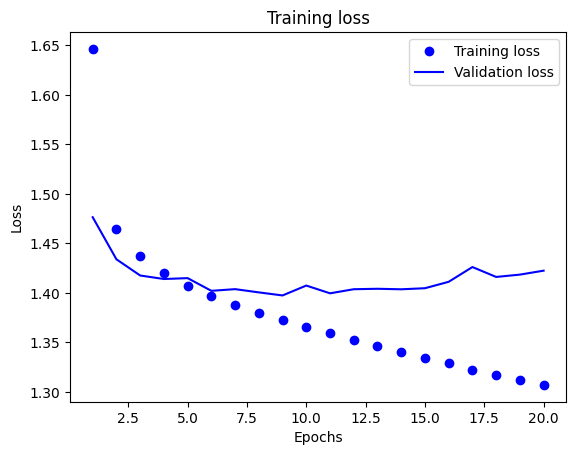

In [136]:
loss = H.history['loss'] 
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

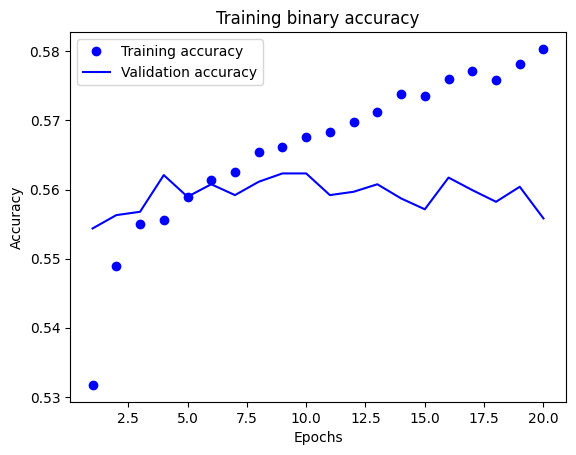

In [137]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training binary accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [138]:
max(val_acc)

0.5623265504837036

259/259 [==============================] - 1s 2ms/step


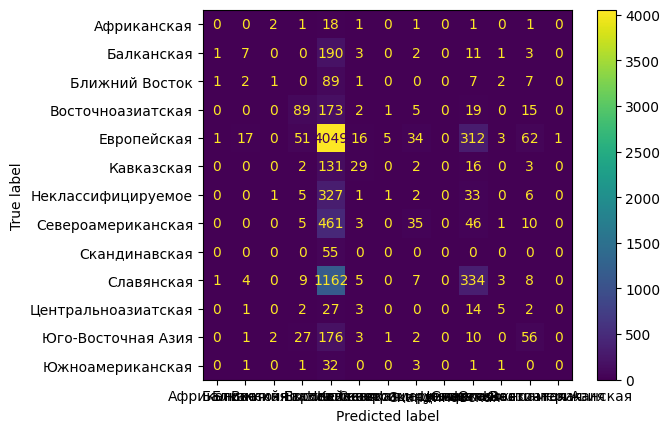

In [139]:
matrix = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(model.predict(x_val), axis=1))
ConfusionMatrixDisplay(matrix, display_labels=list(all_cuisines.keys())).plot()

## Подготовка к CNN

In [140]:
data = ingredients_lemmatized.apply(lens.Each().modify(lambda x: ingredients_numbering_dict[x]))

In [141]:
data[:2]

id
14247    [2459, 3681, 2629, 627, 749, 2069, 3692, 4033]
14248                      [3887, 1171, 968, 2629, 329]
Name: ingredients, dtype: object

In [142]:
data = pad_sequences(data, padding='post', value=0)
labels = to_categorical(np.array(df_for_learning['cuisine_group_mark']), num_classes=len(all_cuisines))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

VALIDATION_SPLIT = 0.2
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [143]:
max_length = len(data[0])
max_length

40

In [144]:
#Эта матрица будет использоваться для слоя Embedding в keras
ingredients_embeddings_matrix = np.zeros((len(all_ingredients_list), dim))
ingredients_embeddings_matrix.shape
for ingr in all_ingredients_list:
    ingredients_embeddings_matrix[ingredients_numbering_dict[ingr]] = ingredients_embeddings_dict[ingr]
ingredients_embeddings_matrix.shape

(4406, 302)

## Обучение CNN

In [145]:
embedding_layer = layers.Embedding(len(ingredients_embeddings_dict),
                            dim,
                            weights=[ingredients_embeddings_matrix],
                            input_length=max_length,
                            trainable=False)
# trainable=True позволит до обучаться эмбеддингам на нашем датасете

In [167]:
#первая архитектура CNN
# sequence_input = layers.Input(shape=(max_length,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)
# x = layers.Conv1D(64, 2, activation='relu')(embedded_sequences)
# x = layers.GlobalMaxPool1D()(x)
# x = layers.Flatten()(x)
# x = layers.Dense(32, activation='relu')(x)
# preds = layers.Dense(len(all_cuisines), activation='softmax')(x)

#вторая архитектура CNN
sequence_input = layers.Input(shape=(max_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
arr = []
for i in [2,3,4]:
    x = layers.Conv1D(2**(7-i), i, activation='relu')(embedded_sequences)
    arr.append(layers.GlobalMaxPool1D()(x))

x = layers.Concatenate()(arr)
x = layers.Flatten()(x)
# x = layers.Dense(32, activation='relu')(x)
preds = layers.Dense(len(all_cuisines), activation='softmax')(x)



model2 = keras.Model(sequence_input, preds)
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



In [168]:
model2.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 40, 302)      1330612     ['input_24[0][0]']               
                                                                                                  
 conv1d_26 (Conv1D)             (None, 39, 32)       19360       ['embedding_4[6][0]']            
                                                                                                  
 conv1d_27 (Conv1D)             (None, 38, 16)       14512       ['embedding_4[6][0]']            
                                                                                           

In [163]:
EPOCHS = 200
H = model2.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=EPOCHS, batch_size=128)

Epoch 1/200
259/259 [==============================] - 6s 23ms/step - loss: 1.5231 - accuracy: 0.5446 - val_loss: 1.4675 - val_accuracy: 0.5526
Epoch 2/200
259/259 [==============================] - 5s 20ms/step - loss: 1.4026 - accuracy: 0.5597 - val_loss: 1.4197 - val_accuracy: 0.5605
Epoch 3/200
259/259 [==============================] - 5s 20ms/step - loss: 1.3581 - accuracy: 0.5687 - val_loss: 1.3910 - val_accuracy: 0.5662
Epoch 4/200
259/259 [==============================] - 5s 20ms/step - loss: 1.3291 - accuracy: 0.5771 - val_loss: 1.3981 - val_accuracy: 0.5570
Epoch 5/200
259/259 [==============================] - 6s 22ms/step - loss: 1.3042 - accuracy: 0.5821 - val_loss: 1.3716 - val_accuracy: 0.5643
Epoch 6/200
259/259 [==============================] - 5s 20ms/step - loss: 1.2828 - accuracy: 0.5878 - val_loss: 1.3788 - val_accuracy: 0.5580
Epoch 7/200
259/259 [==============================] - 5s 21ms/step - loss: 1.2642 - accuracy: 0.5925 - val_loss: 1.3714 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
loss = H.history['loss'] 
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training binary accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
max(val_acc)

In [ ]:
matrix = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(model2.predict(x_val), axis=1))

In [ ]:
ConfusionMatrixDisplay(matrix, display_labels=list(all_cuisines.keys())).plot()

In [118]:
all_cuisines

{'Африканская': 0,
 'Балканская': 1,
 'Ближний Восток': 2,
 'Восточноазиатская': 3,
 'Европейская': 4,
 'Кавказская': 5,
 'Неклассифицируемое': 6,
 'Североамериканская': 7,
 'Скандинавская': 8,
 'Славянская': 9,
 'Центральноазиатская': 10,
 'Юго-Восточная Азия': 11,
 'Южноамериканская': 12}

In [166]:
2**4

16